# plotting hovmoller for given spectral index
- [x] bring in transect
- [x] view in ipyleaflet
- [x] load in datacube data
- [x] make into pandas df
- [x] change distances to meters (* 30)
- [x] make sure seaward end is always first tick
- [x] export as csv 
- [ ] plot up through pandas (not xarray - although not fully neccessary) and export plot with auto name similar to csv
- [ ] make plot outputs look nice (text etc)
- [ ] make into func to loop through for multiple inputs (could do config input for dates/indices/colour ramp appropriate for index, vector files)

In [1]:
%matplotlib inline
import os, sys

import numpy as np
import xarray as xr
import rasterio
import geopandas as gpd
import fiona

import shapely.geometry
from shapely.geometry import shape
from shapely.geometry import Point

import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib import colors
from matplotlib import pyplot as plt
import matplotlib.dates
import folium

import datacube
from datacube.utils import geometry
from datacube.drivers.netcdf import write_dataset_to_netcdf
dc = datacube.Datacube(app='mangrove typology')

from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map
from dea_tools.bandindices import calculate_indices

sys.path.insert(1, '/home/jovyan/code/DP_KNP/misc_funcs')
from plotting_CO import display_map_line

In [2]:
# This defines the function that converts a linear vector file into a string of x,y coordinates

def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }

def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))

In [18]:
# need to be WGS84 coordinate system for transects
transect_file = './OpenCoastTransectsGulf/T110.shp'

In [19]:
# Define temporal range
start_of_epoch = '1995-01-01' 
end_of_epoch =  '2000-12-31'
print ('temporal range is ' + start_of_epoch + ' to ' + end_of_epoch)

temporal range is 1995-01-01 to 2000-12-31


In [20]:
# use fiona module to open the shape file
transect = fiona.open(transect_file)

geom_ = shape(transect[0]['geometry'])
geom_query_ = geom_query(geom=geom_)

query = {'time': (start_of_epoch, end_of_epoch)}

query.update(geom_query(geom=geom_, geom_crs=transect.crs_wkt))

In [21]:
display_map_line(query['x'], query['y'])

In [22]:
# just checking that end lat/long of transect is in the ocean (to make sure data is displayed correctly later on)

# Create a folium map centered around the given coordinates
map_object = folium.Map(location=[query['y'][1], query['x'][1]], zoom_start=15,
        tiles="http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",
        attr="Google")

# Add a marker for the specified point
folium.Marker(location=[query['y'][1], query['x'][1]], popup='Your Point').add_to(map_object)
display(map_object)


In [23]:
%%time
# select the spectral index you want
index_selection = 'NDVI'

ds = load_ard(dc=dc, 
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
              min_gooddata=0.99, 
              output_crs='EPSG:3577',
              skip_broken_datasets=True,
              ls7_slc_off=True,
              resolution=(-30, 30),
              group_by='solar_day',
              **query)

ds_index = calculate_indices(ds,
                       index=index_selection,
                       collection='ga_ls_3',
                       drop=True,
                       inplace=False)

ds_index = ds_index[index_selection]

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 60 out of 106 time steps with at least 99.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 60 time steps
Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
CPU times: user 3min 5s, sys: 1min 6s, total: 4min 11s
Wall time: 3min 51s


In [24]:
# Compress 
crs_wkt = ds.crs
geom_w = warp_geometry(geom_, query['crs'], crs_wkt)

In [25]:
dist = [i for i in range(0, int(geom_w.length), 30)]

points = list(zip(*[geom_w.interpolate(d).coords[0] for d in dist])) # py3

In [26]:
def check_end_coordinates_outside_polygon(gpkg_path, lat, lon):
    # Load the coastline GeoPackage file
    gdf = gpd.read_file(gpkg_path)

    # Create a Shapely Point from the provided coordinates
    point = Point(lon, lat)

    # Check if the point is within any of the polygons in the GeoDataFrame
    within_polygon = gdf.geometry.contains(point).any()

    return within_polygon

# Example usage
gpkg_path = './data/aust_mainland_islands_dissolve_EPSG4326.gpkg'
latitude = query['y'][1]  # Replace with your actual latitude
longitude = query['x'][1]  # Replace with your actual longitude

result = check_end_coordinates_outside_polygon(gpkg_path, latitude, longitude)

if result:
    print("End coordinates are within the coastline polygon.")
    # change the load of coords so that landward to seaward is displayed left to right
    y_dim = np.asarray(points[1])
    y_dim = y_dim[::-1]
    x_dim = np.asarray(points[0])
    x_dim = x_dim[::-1]
    
else:
    print("End coordinates are outside the coastline polygon.")
    # no need to change as load of coords is already in format for landward to seaward to be displayed left to right
    y_dim = np.asarray(points[1])
    x_dim = np.asarray(points[0])

End coordinates are outside the coastline polygon.


In [27]:
hov_data = ds_index.sel(x=xr.DataArray(x_dim, dims='distance'),
                        y=xr.DataArray(y_dim, dims='distance'),
                        method='nearest')

In [28]:
# Convert DataArray to DataFrame
df = hov_data.to_dataframe(name='value').reset_index()

# Pivot the DataFrame
df_pivoted = df.pivot(index='time', columns='distance', values='value')
# make column headings into meters (* 30)
df_pivoted.columns = (df_pivoted.columns.astype(int) * 30).astype(str)

# for saving, add in easier to read column for time
df_pivoted.insert(0, 'year_month_day', df_pivoted.index.strftime('%Y-%m-%d'))

# save as csv
df_pivoted.to_csv('./output/' + os.path.splitext(os.path.basename(transect_file))[0] + '_' + 
                  start_of_epoch.split('-')[0] + '_' + end_of_epoch.split('-')[0] + '_' + index_selection + '.csv', 
                  index=False)

df_pivoted

distance,year_month_day,0,30,60,90,120,150,180,210,240,...,1800,1830,1860,1890,1920,1950,1980,2010,2040,2070
time,,,,,,,,,,,,,,,,,,,,,
1995-02-01 00:10:48.652928,1995-02-01,0.489624,0.249028,0.173272,0.171429,0.172557,0.161098,0.182428,0.182428,0.184496,...,0.271754,0.271754,-0.084507,-0.051771,-0.045289,-0.093580,-0.061412,0.026855,0.030383,0.030383
1995-03-21 00:08:51.104621,1995-03-21,0.579383,0.342809,0.284815,0.241473,0.274608,0.282243,0.226267,0.226267,0.261982,...,0.291871,0.291871,-0.272980,-0.372773,-0.341735,-0.388037,-0.341735,-0.341735,-0.388037,-0.341735
1995-04-06 00:08:12.572046,1995-04-06,0.552198,0.291265,0.203480,0.215161,0.196210,0.216037,0.239410,0.239410,0.229503,...,0.348881,0.348881,-0.284444,-0.480984,-0.503185,-0.481236,-0.481236,-0.520897,-0.501591,-0.520897
1995-04-22 00:07:32.037590,1995-04-22,0.508891,0.288826,0.176947,0.163961,0.166444,0.179967,0.161949,0.161949,0.231583,...,0.331089,0.331089,-0.567652,-0.712519,-0.615591,-0.635669,-0.561927,-0.581140,-0.520480,-0.520480
1995-05-24 00:06:05.583471,1995-05-24,0.521231,0.285563,0.130847,0.129419,0.130604,0.146381,0.208378,0.208378,0.231946,...,0.315315,0.315315,-0.673740,-0.534527,-0.676020,-0.695078,-0.695078,-0.695078,-0.695078,-0.676433
1995-06-09 00:05:19.354551,1995-06-09,0.453917,0.223323,0.140674,0.115819,0.146391,0.158635,0.190195,0.190195,0.256866,...,0.276151,0.276151,-0.387130,-0.371232,-0.296102,-0.275497,-0.360656,-0.405405,-0.425703,-0.465318
1995-07-11 00:03:53.216515,1995-07-11,0.380599,0.181433,0.101958,0.099139,0.112393,0.133692,0.146888,0.146888,0.266092,...,0.206308,0.206308,-0.786982,-0.772586,-0.773700,-0.627451,-0.790665,-0.652741,-0.652741,-0.652741
1995-08-12 00:02:27.406208,1995-08-12,0.318700,0.192711,0.110851,0.109274,0.131431,0.155485,0.197477,0.197477,0.251024,...,0.304348,0.304348,0.090160,0.065197,0.043331,0.045419,0.045419,0.027318,0.027318,0.027318
1995-08-28 00:01:42.873734,1995-08-28,0.328198,0.197494,0.102032,0.127797,0.140267,0.172597,0.199384,0.199384,0.236736,...,0.264750,0.264750,0.079163,0.036339,0.075022,0.095436,0.076672,0.058965,0.058965,0.041831


In [29]:
# This controls the colour map used for plotting NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]

ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N, clip=True)

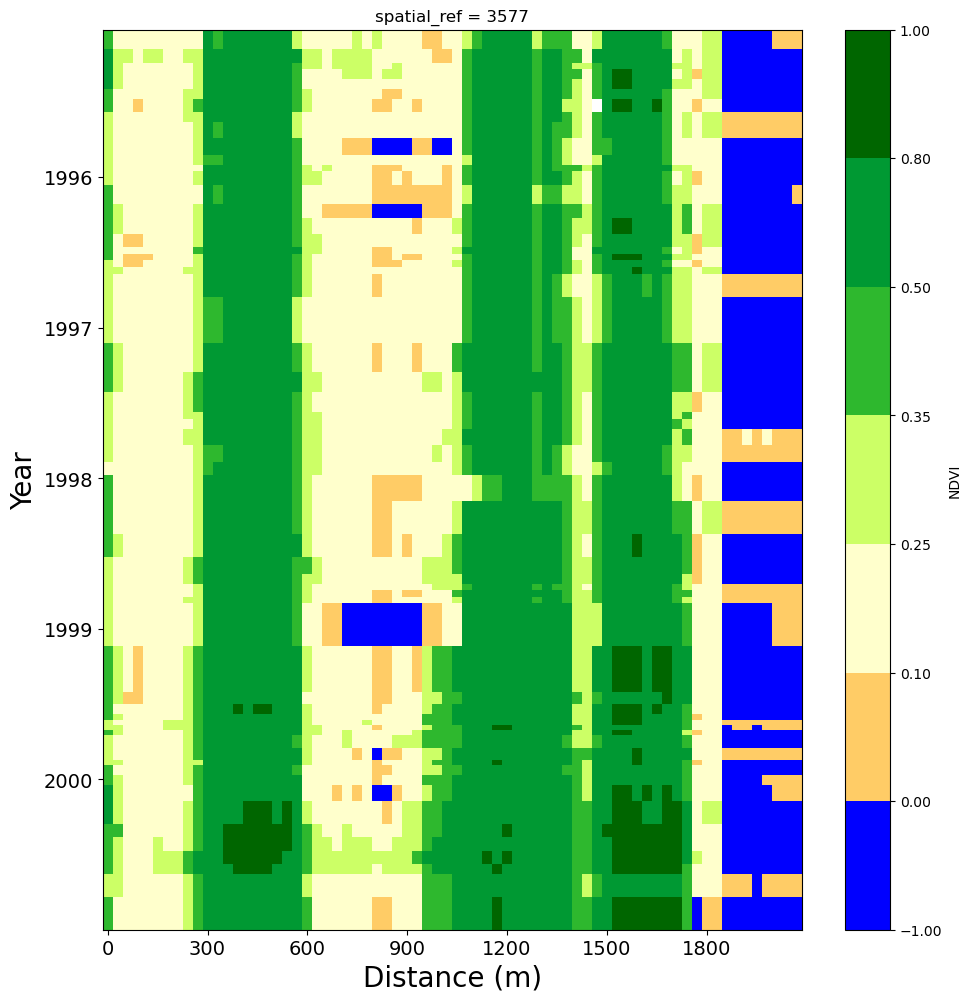

In [30]:
fig = plt.figure(figsize=(11.27,11.69))

hov_data.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm, vmin=-1, vmax =1)
# plt.axis([0, hov_multi_ndvi_sel.distance.max(), '2010-01-01' , '2020-01-01'])
matplotlib.rcParams.update({'font.size': 10})


# Function to modify x-axis tick labels by multiplying by 30 (from pixels to distance (m))
def multiply_by_30(value, pos):
    return int(value * 30)
# Apply the custom function to the x-axis tick labels
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(multiply_by_30))

plt.xlabel('Distance (m)', fontsize ='20')
plt.ylabel('Year', fontsize ='20')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# # save plot to file
# plt.savefig('{}{}_HovPlot_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
#             bbox_inches='tight', dpi=300)
plt.show()